# Building a CNN Classifier in PyTorch
In this section the steps to build a Convolutional Neural Network (CNN) classifier are detailed. The task is to classify a set of images from the animal kingdom into 20 classes (Lion, Elephant, etc...). You are invited to have a play around with the code. There are also a series of tasks aimed at developing you PyTorch coding skills!

**Authors**: Harry Coppock hgc19@imperial.ac.uk, Luca Grillotti luca.grillotti16@imperial.ac.uk


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.animation as animation

## Setting up the GPU


In [4]:
# device selection - Colab offers free GPUs!
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
  print('Please first activate the GPU by going Runtime>Change Runtime type')
  device = torch.device("cpu")
print('The device that will be used is:',device)

The device that will be used is: cuda:0


## If you want to save files to the google drive you need to first mount the drive:

## Importing subset of Imagenet, termed NaturalImageNet
Made for the purpose of this tutorial  (to make the learning process more fun!) NaturalImageNet contains 20 classes all selected from the animal kindom!

In [7]:
!unzip /content/NaturalImageNet.zip

Streaming output truncated to the last 5000 lines.
  inflating: NaturalImageNet/koala/2079170318_027847a169.jpg  
  inflating: NaturalImageNet/koala/90554818_6b6a3dbe5f.jpg  
  inflating: NaturalImageNet/koala/2219885959_b3c02e33b9.jpg  
  inflating: NaturalImageNet/koala/438292349_e54d22fb75.jpg  
  inflating: NaturalImageNet/koala/400208524_a972de2ec2.jpg  
  inflating: NaturalImageNet/koala/1446368071_459bcadffe.jpg  
  inflating: NaturalImageNet/koala/813316157_952e790400.jpg  
  inflating: NaturalImageNet/koala/567958519_76fa374931.jpg  
  inflating: NaturalImageNet/koala/2232151966_8e6abb2ecc.jpg  
  inflating: NaturalImageNet/koala/436288441_5848be4336.jpg  
  inflating: NaturalImageNet/koala/429993653_03b9dcfb86.jpg  
  inflating: NaturalImageNet/koala/436301217_8260012edc.jpg  
  inflating: NaturalImageNet/koala/933876592_22b2e04ef4.jpg  
  inflating: NaturalImageNet/koala/438294880_270a58911e.jpg  
  inflating: NaturalImageNet/koala/2181774419_a4f02420d9.jpg  
  inflating: Na

In [8]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html


transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

path = '/content/NaturalImageNet'
dataset = datasets.ImageFolder(path, transform=transform)

# Create train test split
n = len(dataset)
n_test = 1000 # use 1000 images as test set

train_set, test_set = torch.utils.data.random_split(dataset, [n-n_test, n_test])

# The number of images to process in one go. If you run out of GPU
# memory reduce this number! 
batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)


In [9]:
def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


In [10]:
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:9, :, :, :]

## Visualising the dataset:

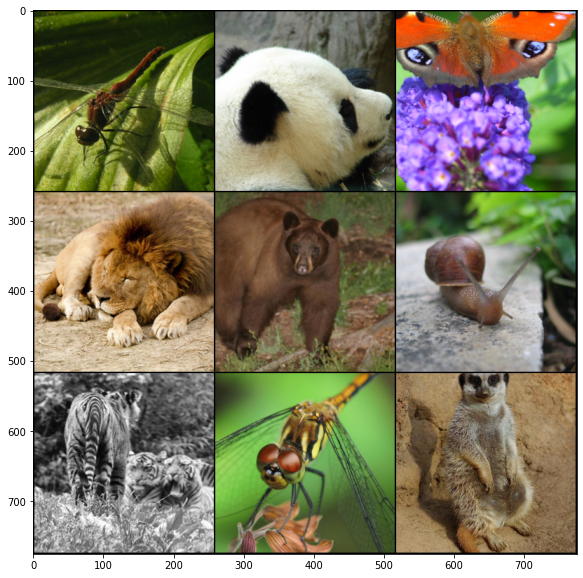

In [11]:
img = make_grid(denorm(fixed_input), nrow=3, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
show(img)
# plt.savefig('/content/drive/My Drive/Colab Notebooks/Phd-Teaching-Lecture/MNIST.png', bbox_inches='tight')

## CNN Classifier with Pytorch

First have a play with all the code shown below and try to understand what it does.

Disclaimer: exactly what and how a convolution works is not part of this course. Rather treat it as a function which takes an inputs and a series of parameters and returns an output. For more information regarding convolutions please refer to the following links. 

An animation of an example convolution with in_channels = 1, out_channels=1, kernel_size = (3,3), padding = 1 and stride=1:

![conv](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)
- You can find a very nice CNN explainer here: https://poloclub.github.io/cnn-explainer/
- And some nice convolution visualisation here: https://github.com/vdumoulin/conv_arithmetic

**[TASK 3]** When hyperparameter tuning it is important to base your decisions on a validation set NOT the test set. To this end create a new dataloader called validation_dataloader. This will allow your test set to be truly unseen data!


**[TASK 4]** Here we have a simple convolution classifier. Once you have familiarised yourself with the architecture, spend some time trying to improve the accuracy of the model. Some areas which could prove fruitful:

- different optimizers (Adam, RMSProp, SGD, ...)
- different activation functions (relu, tanh, sigmoid, ...)
- add of remove some neurons
- add of remove some layers
- batch normalisation
- differential learning rates
- data augmentation
- residual connections

(the list is endless)

I will be interested in seeing your solutions. If you want to share, copy and paste your code into an email to hgc19@ic.ac.uk, with the final test accuracy in the subject of the email.

## Define hyperparameters

In [12]:
# 1 epoch = one complete pass through the dataset
num_epochs = 10

# How fast to update the weights of the networks
# nice interactive tool to visualise effect of lr and momentum on SGD:
# https://distill.pub/2017/momentum/
learning_rate  = 1e-3 


## Define our model

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Here, we will use nn.Sequential to directly define the sequence of operations that will be performed IN ORDER by our model.

        # You can find a very nice CNN explainer here: https://poloclub.github.io/cnn-explainer/
        # And some nice convolution visualisation here: https://github.com/vdumoulin/conv_arithmetic

        # Defining all the operations that will be performed IN ORDER by our model. 
        blocks = [
            # First the data goes through a 2D convolutional Layer (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
            # in_channels=3 as each image has 3 channels (one for the red, one for the green and one for the blue color)
            # out_channels=32 corresponds to the number of channels outputted by the Conv2d Layer.
            # We use a kernel of size 3 to perform the convolutions
            # And a padding of 1 around each image in order to keep the same image dimensions in (in_channels) and (out_channels)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True), # Then it goes to a ReLU Activation function 
            nn.BatchNorm2d(32), # Performing a normalisation over the whole batch of data.
            nn.MaxPool2d(2,2), # Pooling layer, downscaling the images by 2 
            nn.Conv2d(32,64,3,padding=1), # And so on...
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,32,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,32,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,3,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        ]

        # Save the list of operations declared above as an nn.Sequential attribute
        self.blocks = nn.Sequential(*blocks) 

        self.FC1 = nn.Linear(192, 20)

    def forward(self, input_data):
        x = self.blocks(input_data) # Data passed to all the operations in nn.Sequential
        out = self.FC1(x.view(input_data.size()[0], -1))
        return out



## Define our training and test methods

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train(epoch, loader_train, loader_test, model, device, optimizer, scheduler):
    
    loader_train = tqdm(loader_train, position=0)
    criterion = nn.CrossEntropyLoss()

    for i, (img, label) in enumerate(loader_train):
        model.zero_grad()
        # sending the images to the gpu!
        img = img.to(device)
        label = label.to(device)
        predicts_soft = model(img) # (batch, #classes)
        loss = criterion(predicts_soft, label)
        loss.backward()

        # get accuracy
        predicts = torch.argmax(predicts_soft, dim=1)
        correct = (predicts == label).float()
        accuracy = correct.sum() / label.numel()

        if scheduler is not None:
            scheduler.step()
        optimizer.step()

        lr = optimizer.param_groups[0]['lr']

        loader_train.set_description(
            (
                f'epoch: {epoch + 1}; acc: {accuracy.item():.5f}; '
                f'loss: {loss.item():.3f}'
            )
        )


def test(model, device, loader_test, confusion=False):

    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_correct = 0
    total_loss = 0
    total = 0
    for j, (test_img, test_label) in enumerate(loader_test):



        with torch.no_grad():
            test_img = test_img.to(device)
            test_label = test_label.to(device)
            predicts_soft = model(test_img) # (batch, #classes)
            test_loss = criterion(predicts_soft, test_label)
            total_loss += test_loss

        # get accuracy
        predicts = torch.argmax(predicts_soft, dim=1)
        correct = (predicts == test_label).float()
        total_correct += correct.sum()
        total += test_label.numel()


        if j == 0 and confusion:
            stack_labels = test_label
            stack_predicts = predicts
        elif confusion:
            stack_labels = torch.cat([stack_labels, test_label], 0)
            stack_predicts = torch.cat([stack_predicts, predicts], 0)

    model.train()
    
    print(f'test loss: {total_loss.item()/j}')
    print(f'test acc: {total_correct/total}')

    if confusion:
      
      # Plotting the confusion matrix
      labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
        'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
        'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
      cm = confusion_matrix(stack_labels.cpu().numpy(), stack_predicts.cpu().numpy())
      ax= plt.subplot()
      sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

      # labels, title and ticks
      ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
      ax.set_title('Confusion Matrix');
      ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels);
      plt.show()

      # lets see a sample of the images which were classified incorrectly!
      test_labels_check = correct.cpu().numpy()
      incorrect_indexes = np.where(test_labels_check == 0)

      test_img = test_img.cpu()
      samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                          padding=2, normalize=False, range=None, 
                          scale_each=False, pad_value=0)
      plt.figure(figsize = (20,10))
      plt.title('Incorrectly Classified Instances')
      show(samples)
      labels = np.asarray(labels)
      print('Predicted label',labels[predicts[incorrect_indexes].cpu().numpy()[:9]])
      print('True label', labels[test_label[incorrect_indexes].cpu().numpy()[:9]])
      print('Corresponding images are shown below')

 

  0%|          | 0/164 [00:00<?, ?it/s]

Total number of parameters is: 52151
Model(
  (blocks): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True

  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 3.047306878226144
test acc: 0.24500000476837158


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.2010116577148438
test acc: 0.3960000276565552


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.232337406703404
test acc: 0.43400001525878906


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.0057859420776367
test acc: 0.4610000252723694


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 2.11710330418178
test acc: 0.4440000355243683


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 1.9671688079833984
test acc: 0.4650000333786011


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 1.850578989301409
test acc: 0.5080000162124634


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 1.8726791654314314
test acc: 0.49500003457069397


  0%|          | 0/164 [00:00<?, ?it/s]

test loss: 1.8571861812046595
test acc: 0.503000020980835


epoch: 10; acc: 0.58333; loss: 1.363: 100%|██████████| 164/164 [01:18<00:00,  2.10it/s]


test loss: 1.827110971723284
test acc: 0.49500003457069397
test loss: 1.831808090209961
test acc: 0.49500003457069397


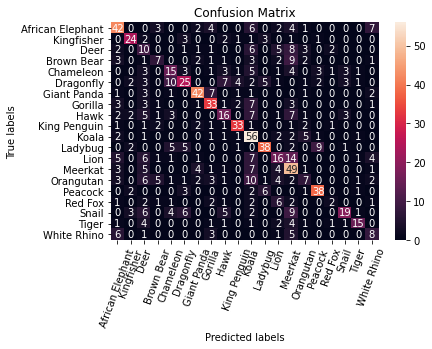

Predicted label ['Meerkat' 'Tiger' 'Koala' 'Hawk' 'Deer' 'Koala' 'Koala' 'Chameleon'
 'Koala']
True label ['White Rhino' 'Orangutan' 'Gorilla' 'Dragonfly' 'Koala' 'Tiger'
 'Kingfisher' 'Giant Panda' 'Orangutan']
Corresponding images are shown below


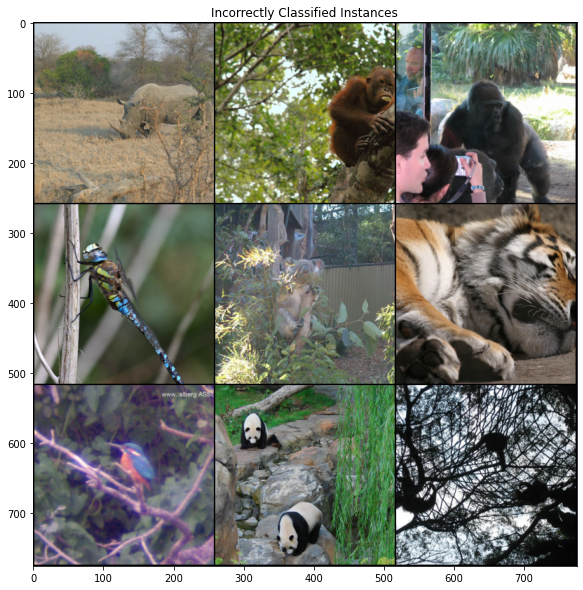

In [15]:
# Training the model using ADAM optimiser

from tqdm import tqdm

model = Model().to(device) # Passing the classifier implemented above to the GPU
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = None

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

# Train model
for i in range(num_epochs):
    model.train()
    train(i, loader_train, loader_test, model, device, optimizer, scheduler)
    test(model, device, loader_test)

test(model, device, loader_test, confusion=True)